# TimeQuant Quickstart

Demo of a streaming **Gaussian-Quantile tokenizer** for continuous time series.
- Univariate online tokenization with running mean/variance.

> This notebook is standalone and dependency-light (NumPy, Scipy, Sklearn, Matplotlib & Seaborn).

In [84]:
#@title Imports

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# -------------------------------
# 1) Welford (no forgetting)
# -------------------------------

class RunningStatsWelford:
    """
    Streaming mean/variance (unweighted) using Welford's algorithm.
    - mean: running mean
    - var_sample: unbiased sample variance (M2/(n-1))
    - var_population: population variance (M2/n)
    """
    def __init__(self, eps: float = 1e-12):
        self.n = 0
        self._mean = 0.0
        self._M2 = 0.0
        self.eps = eps

    def update(self, x):
        x = float(x)
        self.n += 1
        delta = x - self._mean
        self._mean += delta / self.n
        delta2 = x - self._mean
        self._M2 += delta * delta2

    @property
    def count(self):
        return self.n

    @property
    def mean(self):
        if self.n == 0:
            raise ValueError("No data seen yet. Call update() first.")
        return self._mean

    @property
    def var_population(self):
        if self.n == 0:
            return 0.0
        return max(self._M2 / max(self.n, 1), 0.0)

    @property
    def var_sample(self):
        if self.n < 2:
            return 0.0
        return max(self._M2 / (self.n - 1), 0.0)

    @property
    def std(self):
        return float(np.sqrt(self.var_sample + self.eps))


# ----------------------------------------------
# 2) Exponentially-weighted stats (with forgetting)
#    Reduces to Welford when decay = 1.0
# ----------------------------------------------

class RunningStats:
    """
    Weighted Welford with geometric decay of past weights.

    Parameters
    ----------
    decay : float in (0, 1], default=0.99999
        Each update multiplies all *past* sample weights by `decay`, then
        adds the new sample with raw weight 1. The normalized weight of the
        new sample is 1 / W_t, which tends to (1 - decay) as t grows.
        Special case: decay=1.0 reproduces standard Welford exactly.

    Notes
    -----
    - We maintain:
        W_t   = total raw weight          (W_t = decay * W_{t-1} + 1)
        S_t   = sum of squared raw weights(S_t = decay^2 * S_{t-1} + 1)
        mean  = weighted mean
        M2    = weighted sum of squared deviations
      Then the **unbiased weighted** variance is:
        var = M2 / ( W_t - S_t / W_t )
      (the standard reliability-weights correction).
    """
    def __init__(self, decay: float = 1-1e-5, eps: float = 1e-12):
        if not (0 < decay <= 1.0):
            raise ValueError("`decay` must be in (0, 1].")
        self.decay = float(decay)
        self.eps = eps

        self.n = 0
        self._mean = 0.0
        self._M2 = 0.0
        self._W = 0.0         # total raw weight
        self._Wsq = 0.0       # sum of squared raw weights

    def update(self, x):
        x = float(x)

        if self.n == 0:
            # Initialize with the first sample (normalized from the start)
            self.n = 1
            self._mean = x
            self._M2 = 0.0
            self._W = 1.0
            self._Wsq = 1.0
            return

        self.n += 1

        # 1) Decay existing weights and M2 (mean unchanged by uniform rescaling)
        a = self.decay
        self._W   = a * self._W
        self._Wsq = (a * a) * self._Wsq
        self._M2  = a * self._M2

        # 2) Add new sample with raw weight 1
        #    Weighted-Welford update
        delta = x - self._mean
        self._W += 1.0
        self._Wsq += 1.0
        self._mean += delta / self._W    # new-sample normalized weight = 1/W
        delta2 = x - self._mean
        self._M2 += delta * delta2

    @property
    def count(self):
        return self.n

    @property
    def mean(self):
        if self.n == 0:
            raise ValueError("No data seen yet. Call update() first.")
        return self._mean

    @property
    def var(self):
        """
        Unbiased weighted variance using reliability-weights correction:
        denom = W - Wsq/W
        """
        if self.n < 2:
            return 0.0
        denom = self._W - (self._Wsq / max(self._W, self.eps))
        if denom <= 0:
            return 0.0
        return max(self._M2 / denom, 0.0)

    @property
    def std(self):
        return float(np.sqrt(self.var + self.eps))

    @property
    def effective_count(self):
        """Handy diagnostic: current total raw weight W_t."""
        return self._W

In [86]:
# --- Example 1: Welford equivalence at decay=1.0 ---
rng = np.random.default_rng(0)
x = rng.normal(loc=2.5, scale=1.7, size=50_000)

W = RunningStatsWelford()
R = RunningStats(decay=1.0)  # should behave exactly like Welford

for xi in x:
    W.update(xi)
    R.update(xi)

print("== Equivalence check (decay=1.0) ==")
print(f"Mean    Welford: {W.mean:.12f} | RunningStats: {R.mean:.12f}")
print(f"Var     Welford: {W.var_sample:.12f} | RunningStats: {R.var:.12f}")

# hard numerical check
np.testing.assert_allclose(R.mean, W.mean, rtol=0, atol=1e-12)
np.testing.assert_allclose(R.var,  W.var_sample, rtol=0, atol=1e-10)
print("PASS: RunningStats(decay=1.0) == Welford\n")


# --- Example 2: Decay vs classical EMA (moment form) ---

def ema_moment(x, a):
    """
    Classical EMA with fixed step a in (0,1]:
      m_t = (1-a)m_{t-1} + a x_t
      q_t = (1-a)q_{t-1} + a x_t^2
      v_t = q_t - m_t^2
    Returns arrays of (m_t, v_t).
    """
    m = np.empty_like(x, dtype=float)
    v = np.empty_like(x, dtype=float)
    m[0] = x[0]
    q = x[0] * x[0]
    v[0] = q - m[0]**2
    for t in range(1, len(x)):
        m[t] = (1-a) * m[t-1] + a * x[t]
        q    = (1-a) * q      + a * (x[t]**2)
        v[t] = q - m[t]**2
    return m, v

decay = 0.9
a = 1.0 - decay  # steady-state normalized step for our decay scheme

R2 = RunningStats(decay=decay)
m, v = ema_moment(x, a)

means_R2 = []
vars_R2  = []
for xi in x:
    R2.update(xi)
    means_R2.append(R2.mean)
    vars_R2.append(R2.var)

means_R2 = np.array(means_R2)
vars_R2  = np.array(vars_R2)

# Compare after warm-up (first 200 steps)
warmup = 200
dm = np.max(np.abs(means_R2[warmup:] - m[warmup:]))
dv = np.max(np.abs(vars_R2[warmup:]  - v[warmup:]))

print("== Decay vs classical EMA (after warm-up) ==")
print(f"step a = 1 - decay = {a}")
print(f"max |mean_diff|: {dm:.3e}")
print(f"max |var_diff| : {dv:.3e}")

== Equivalence check (decay=1.0) ==
Mean    Welford: 2.501438892021 | RunningStats: 2.501438892021
Var     Welford: 2.898228551128 | RunningStats: 2.898228551128
PASS: RunningStats(decay=1.0) == Welford

== Decay vs classical EMA (after warm-up) ==
step a = 1 - decay = 0.09999999999999998
max |mean_diff|: 4.178e-10
max |var_diff| : 4.840e-01


In [87]:
class QuantileBinner:
    """
    Map standardized scalars z ~ N(0,1) to V *data* tokens in {1..V}.
    Token 0 is reserved for missing / non-finite values.

    boundaries[k] = Φ^{-1}((k+1)/V) for k=0..V-2
    bins: (-inf,b0], (b0,b1], ..., (b_{V-2}, +inf)
    """
    def __init__(self, V: int):
        assert V > 1, "Vocabulary size must be at least 2"
        self.V = int(V)
        qs = np.linspace(0, 1, self.V + 1)[1:-1]  # exclude 0 and 1 to avoid ±inf
        self.boundaries = norm.ppf(qs).astype(np.float32)  # shape (V-1,)

    def encode_scalar(self, z: float) -> int:
        # Non-finite z -> token 0 (missing)
        if not np.isfinite(z):
            return 0
        # Data tokens are 1..V
        idx = int(np.searchsorted(self.boundaries, z, side="right"))
        return idx + 1

    def decode_scalar(self, tok: int) -> float:
        """
        Return the z-space midpoint for the bin. Token 0 -> NaN (missing).
        """
        if tok == 0 or tok < 0 or tok > self.V:
            return np.nan
        tok_idx = tok - 1  # 0..V-1
        if tok_idx == 0:
            lo, hi = -np.inf, self.boundaries[0]
        elif tok_idx == len(self.boundaries):
            lo, hi = self.boundaries[-1], np.inf
        else:
            lo, hi = self.boundaries[tok_idx - 1], self.boundaries[tok_idx]

        # midpoint via CDF mid-quantile
        q_lo = 0.0 if (np.isneginf(lo)) else norm.cdf(lo)
        q_hi = 1.0 if (np.isposinf(hi)) else norm.cdf(hi)
        q_mid = 0.5 * (q_lo + q_hi)
        return float(norm.ppf(q_mid))


class GQTokenizer:
    """
    Gaussian-Quantile tokenizer for a *univariate* time series with optional forgetting.

    Streaming normalization:
        - Maintain running mean/variance with `RunningStats`.
        - `decay=1.0` -> standard Welford (no forgetting).
        - `decay<1.0` -> geometric forgetting of distant past (EMA-like).

    Tokenization:
        1) z-score current x using the *current* running mean/std
        2) map z to a quantile-bin token in {1..V}
        3) token 0 is reserved for missing/non-finite

    Notes
    -----
    - Normalization uses the unbiased weighted variance from RunningStats.
    - During early warm-up when std≈0, we clamp by `denom = max(std, eps)` to avoid huge z.
    """
    def __init__(self, V: int, *, decay: float = 1.0, eps: float = 1e-8):
        """
        Args
        ----
        V : int
            Number of *data* tokens (IDs 1..V). ID 0 is reserved for missing.
        decay : float in (0,1], default 1.0
            Past-weight decay for running stats. 1.0 reproduces Welford.
            Values <1.0 forget the distant past (steady-state step ~ 1-decay).
        eps : float
            Small clamp for numerical stability in z-scoring.
        """
        if not (0 < decay <= 1.0):
            raise ValueError("`decay` must be in (0,1].")
        self.V = int(V)
        self.eps = float(eps)
        self.decay = float(decay)

        # RunningStats is the class we finalized earlier:
        # - decay=1.0 -> Welford
        # - decay<1.0 -> exponentially weighted with unbiased weighted variance
        self.stats = RunningStats(decay=self.decay, eps=eps)
        self.binner = QuantileBinner(self.V)

    def update(self, x: float) -> None:
        """Consume a new sample and update running statistics."""
        self.stats.update(x)

    def encode(self, x: float) -> int:
        """
        Encode x -> token_id.

        Returns
        -------
        int
            0 for missing/non-finite; else an integer in {1..V}.
        """
        # Missing x -> token 0
        if not np.isfinite(x):
            return 0
        # z-score with clamp against tiny std (warm-up)
        denom = max(self.stats.std, self.eps)
        z = (x - self.stats.mean) / denom
        return self.binner.encode_scalar(float(z))

    def decode(self, tok: int) -> float:
        """
        Decode token back to x using *current* running stats snapshot.
        Token 0 -> NaN (missing).
        """
        z = self.binner.decode_scalar(tok)
        if not np.isfinite(z):
            return np.nan
        return float(self.stats.mean + z * max(self.stats.std, self.eps))

In [88]:
# 1) No forgetting (Welford)
tok_w = GQTokenizer(V=16, decay=1.0)
# 2) Forgetting (EMA-like with steady-state step ~ 0.1)
tok_ema = GQTokenizer(V=16, decay=0.9)

rng = np.random.default_rng(0)
x = rng.normal(loc=0.0, scale=1.0, size=1000)

toks_w, toks_ema = [], []
for xi in x:
    tok_w.update(xi)
    tok_ema.update(xi)
    toks_w.append(tok_w.encode(xi))
    toks_ema.append(tok_ema.encode(xi))

print("Example tokens (no forgetting):", toks_w[:10])
print("Example tokens (decay=0.9):   ", toks_ema[:10])

Example tokens (no forgetting): [9, 4, 14, 7, 2, 12, 16, 14, 2, 1]
Example tokens (decay=0.9):    [9, 5, 14, 7, 2, 12, 16, 13, 2, 2]


Using decay=0.99993333 (~memory 15000 samples)
First 20 tokens: [5, 2, 7, 7, 3, 6, 8, 8, 7, 4, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2]

Overall Statistics (ignoring first 50 samples):
  MSE:               24.359303
  RMSE:              4.935514
  Corr(x, x_rec):    0.9876
  Vocab utilization: 8/8 real tokens used
  Token perplexity:  5.551


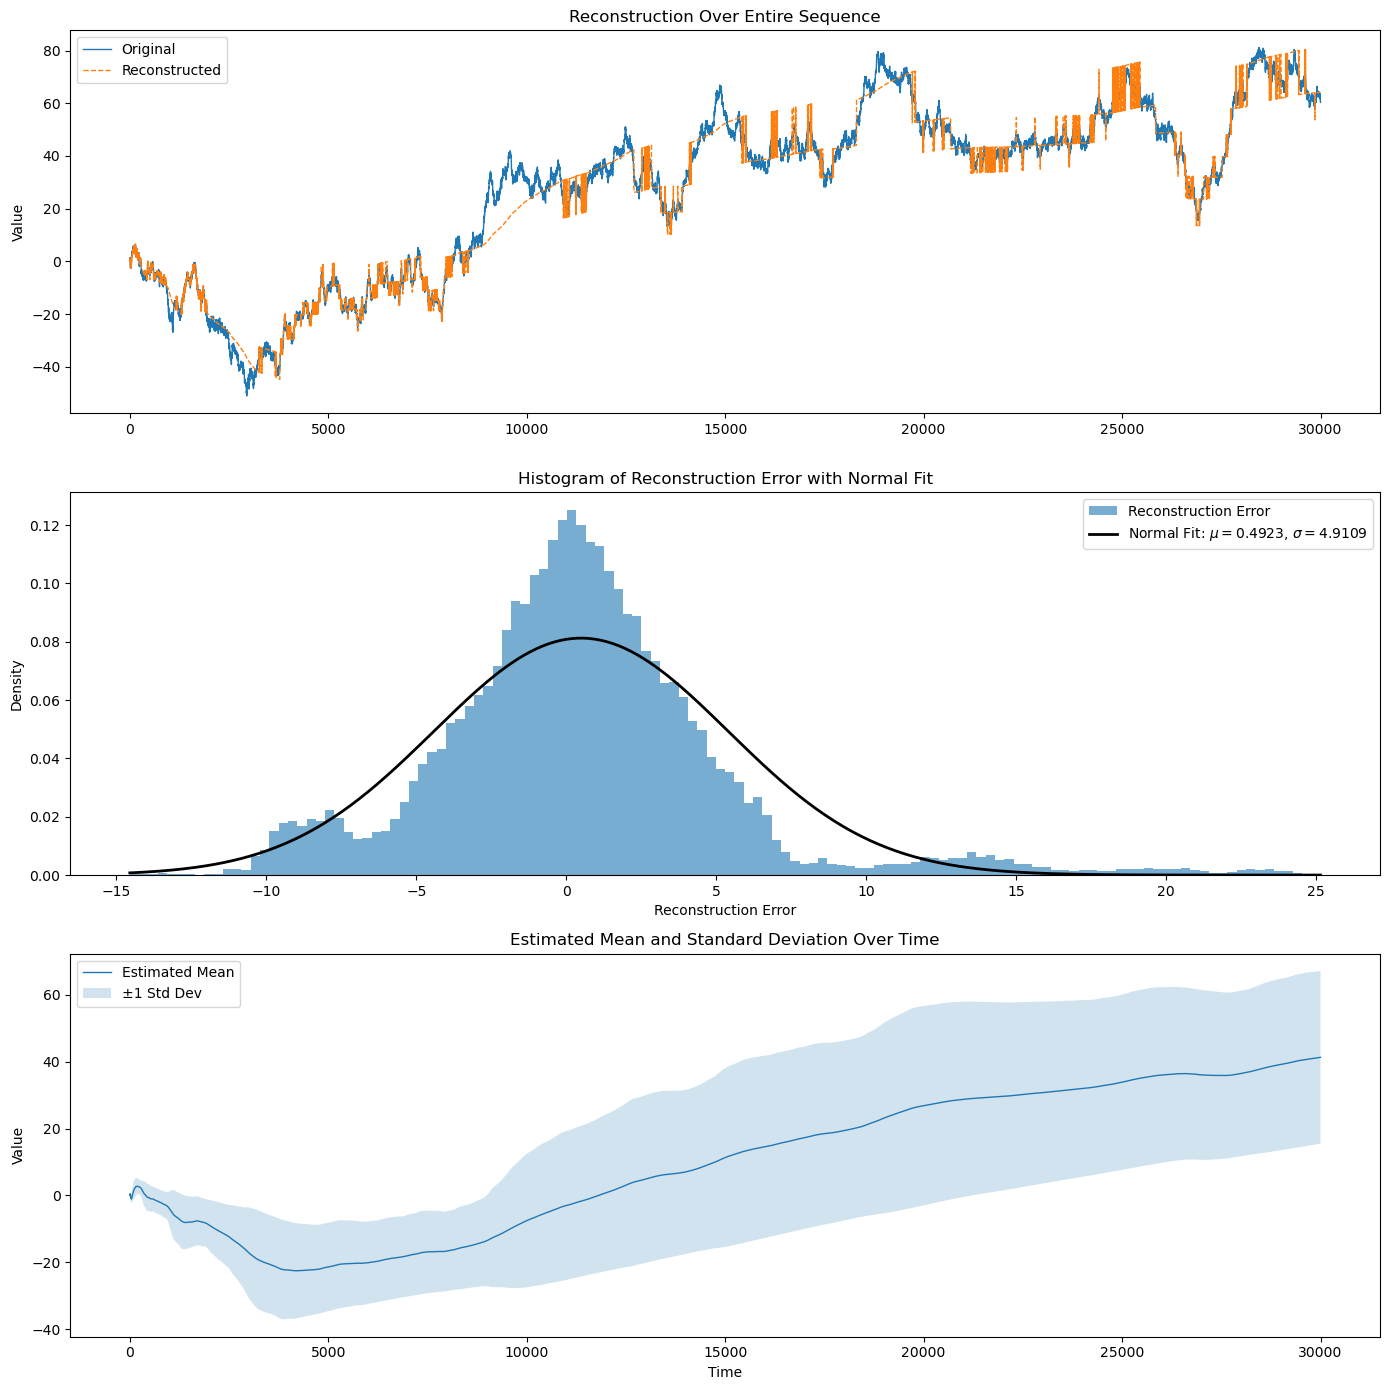

In [89]:
# ----------------------------
# Helpers & configuration
# ----------------------------

def decay_from_memory(mem_len: int) -> float:
    """
    Choose 'decay' so the effective EMA-like memory length is ≈ mem_len samples.
    Relationship: memory ≈ 1 / (1 - decay)  =>  decay ≈ 1 - 1/mem_len.
    """
    if mem_len <= 1:
        return 0.0  # degenerate, but keep the formula simple for typical mem_len >> 1
    return 1.0 - 1.0 / float(mem_len)

RNG_SEED = 0
T        = 30_000
V        = 8
MEM_LEN  = T // 2            # try e.g. 300, 3_000, 30_000 for different forgetting
DECAY    = decay_from_memory(MEM_LEN)
WARMUP   = 50            # optional: ignore the first few steps in metrics

print(f"Using decay={DECAY:.8f} (~memory {int(1/(1-DECAY))} samples)")

# ----------------------------
# Data: non-stationary signal
# ----------------------------

rng = np.random.default_rng(RNG_SEED)
time = np.arange(T)
sinusoidal_component = 5.0 * np.sin(0.0002 * np.pi * time)
random_walk = np.cumsum(rng.normal(0.0, 0.5, size=T))
x = random_walk + sinusoidal_component

# ----------------------------
# Tokenization & reconstruction
# ----------------------------

tok = GQTokenizer(V=V, decay=DECAY)

tokens = np.empty(T, dtype=int)
x_rec  = np.empty(T, dtype=float)
means  = np.empty(T, dtype=float)
stds   = np.empty(T, dtype=float)

for t in range(T):
    xi = float(x[t])
    tok.update(xi)
    tokens[t] = tok.encode(xi)
    x_rec[t]  = tok.decode(tokens[t])
    means[t]  = tok.stats.mean
    stds[t]   = tok.stats.std

print("First 20 tokens:", tokens[:20].tolist())

# ----------------------------
# Metrics
# ----------------------------

err  = x - x_rec
mse  = float(np.mean(err[WARMUP:]**2))
rmse = float(np.sqrt(mse))
corr = float(np.corrcoef(x[WARMUP:], x_rec[WARMUP:])[0, 1])

vals, counts = np.unique(tokens, return_counts=True)
# exclude '0' (missing) from utilization/perplexity
mask_real = (vals != 0)
p = counts[mask_real] / counts[mask_real].sum() if mask_real.any() else np.array([1.0])
perplexity = float(np.exp(-(p * np.log(p + 1e-12)).sum()))
utilization = int(mask_real.sum())

print("\nOverall Statistics (ignoring first", WARMUP, "samples):")
print(f"  MSE:               {mse:.6f}")
print(f"  RMSE:              {rmse:.6f}")
print(f"  Corr(x, x_rec):    {corr:.4f}")
print(f"  Vocab utilization: {utilization}/{V} real tokens used")
print(f"  Token perplexity:  {perplexity:.3f}")

# ----------------------------
# Visualization
# ----------------------------

fig, axes = plt.subplots(3, 1, figsize=(14, 14))  # <-- no sharex

# (1) Original vs reconstructed
ax = axes[0]
ax.plot(time, x, label="Original", linewidth=1)
ax.plot(time, x_rec, "--", label="Reconstructed", linewidth=1)
ax.set_title("Reconstruction Over Entire Sequence")
ax.set_ylabel("Value")
ax.legend()

# (2) Histogram of reconstruction error + normal fit
ax = axes[1]
err_valid = err[np.isfinite(err)][WARMUP:]  # drop warm-up & non-finite just in case
# Use automatic binning or set bins=60 and a tight range based on the data
n, bins, _ = ax.hist(err_valid, bins="auto", density=True, alpha=0.6,
                     label="Reconstruction Error")
mu_hat, sigma_hat = norm.fit(err_valid)
x_fit = np.linspace(bins[0], bins[-1], 400)
ax.plot(x_fit, norm.pdf(x_fit, mu_hat, sigma_hat), "k", lw=2,
        label=fr"Normal Fit: $\mu={mu_hat:.4f}$, $\sigma={sigma_hat:.4f}$")
ax.set_title("Histogram of Reconstruction Error with Normal Fit")
ax.set_xlabel("Reconstruction Error")
ax.set_ylabel("Density")
ax.legend()

# (3) Estimated mean ±1 std over time
ax = axes[2]
ax.plot(time, means, label="Estimated Mean", linewidth=1)
ax.fill_between(time, means - stds, means + stds, alpha=0.2, label="±1 Std Dev")
ax.set_title("Estimated Mean and Standard Deviation Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()

plt.tight_layout()
plt.show()

In [100]:
# Autoencoder-based Multivariate Tokenizer
class AutoencoderTokenizer:
    """
    Multivariate tokenizer using autoencoder + GQTokenizer.
    
    Architecture:
    1. Autoencoder: D-dim input → 1D bottleneck → D-dim reconstruction
    2. GQTokenizer: 1D continuous signal → discrete tokens
    
    This produces a 1D sequence of tokens from D-dimensional time series.
    """
    
    def __init__(self, D, V, hidden_dim=64, num_layers=3, learning_rate=1e-5, decay=1-1e-7):
        """
        Args:
            D: Input dimension
            V: Vocabulary size for GQTokenizer
            hidden_dim: Hidden layer size for autoencoder
            num_layers: Number of hidden layers in encoder and decoder
            learning_rate: Learning rate for autoencoder
        """
        self.D = D
        self.V = V
        self.num_layers = num_layers
        
        # Encoder: D → hidden → ... → hidden → 1
        encoder_layers = [nn.Linear(D, hidden_dim), nn.ReLU()]
        for _ in range(num_layers - 1):
            encoder_layers.append(nn.Linear(hidden_dim, hidden_dim))
            encoder_layers.append(nn.ReLU())
        encoder_layers.append(nn.Linear(hidden_dim, 1))  # 1D bottleneck
        self.encoder = nn.ModuleList(encoder_layers)
        
        # Decoder: 1 → hidden → ... → hidden → D
        decoder_layers = [nn.Linear(1, hidden_dim), nn.ReLU()]
        for _ in range(num_layers - 1):
            decoder_layers.append(nn.Linear(hidden_dim, hidden_dim))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(hidden_dim, D))
        self.decoder = nn.Sequential(*decoder_layers)
        
        # Optimizer
        self.optimizer = optim.AdamW(list(self.encoder.parameters()) + list(self.decoder.parameters()), 
                                   lr=learning_rate)
        
        # GQTokenizer for the 1D bottleneck
        self.gq_tokenizer = GQTokenizer(V, decay=decay)
        
        # Training state
        self.training_step = 0
        
    def encode_continuous(self, x):
        """Encode D-dimensional input to 1D continuous signal."""
        with torch.no_grad():
            x_tensor = torch.tensor(x, dtype=torch.float32)
            out = x_tensor
            for i in range(0, len(self.encoder) - 1, 2):
                out = nn.functional.relu(self.encoder[i](out) + out if i > 0 else self.encoder[i](out))
            encoded = self.encoder[-1](out)
            return encoded.item()
    
    def decode_continuous(self, z):
        """Decode 1D continuous signal to D-dimensional reconstruction."""
        with torch.no_grad():
            z_tensor = torch.tensor([z], dtype=torch.float32)
            return self.decoder(z_tensor).numpy()
    
    def train_step(self, x):
        """Single training step for autoencoder."""
        x_tensor = torch.tensor(x, dtype=torch.float32)
        
        # Forward pass with skip connections
        out = x_tensor
        for i in range(0, len(self.encoder) - 1, 2):
            out = nn.functional.relu(self.encoder[i](out) + out if i > 0 else self.encoder[i](out))
        z = self.encoder[-1](out)  # 1D bottleneck
        x_recon = self.decoder(z)   # D-dim reconstruction
        
        # Reconstruction loss
        loss = nn.functional.mse_loss(x_recon, x_tensor)
        
        # Backward pass
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.training_step += 1
        return loss.item()
    
    def update(self, x):
        """Update both autoencoder and GQTokenizer with new data point."""
        # Train autoencoder
        loss = self.train_step(x)
        
        # Update GQTokenizer with 1D encoding
        z_1d = self.encode_continuous(x)
        self.gq_tokenizer.update(z_1d)
        
        # Optional: print progress
        if self.training_step % 500 == 0:
            print(f"Training step {self.training_step}, autoencoder loss: {loss:.4f}")
    
    def encode(self, x):
        """Encode D-dimensional input to discrete token."""
        z_1d = self.encode_continuous(x)
        return self.gq_tokenizer.encode(z_1d)
    
    def decode(self, token):
        """Decode token to D-dimensional reconstruction."""
        z_1d = self.gq_tokenizer.decode(token)
        return self.decode_continuous(z_1d)


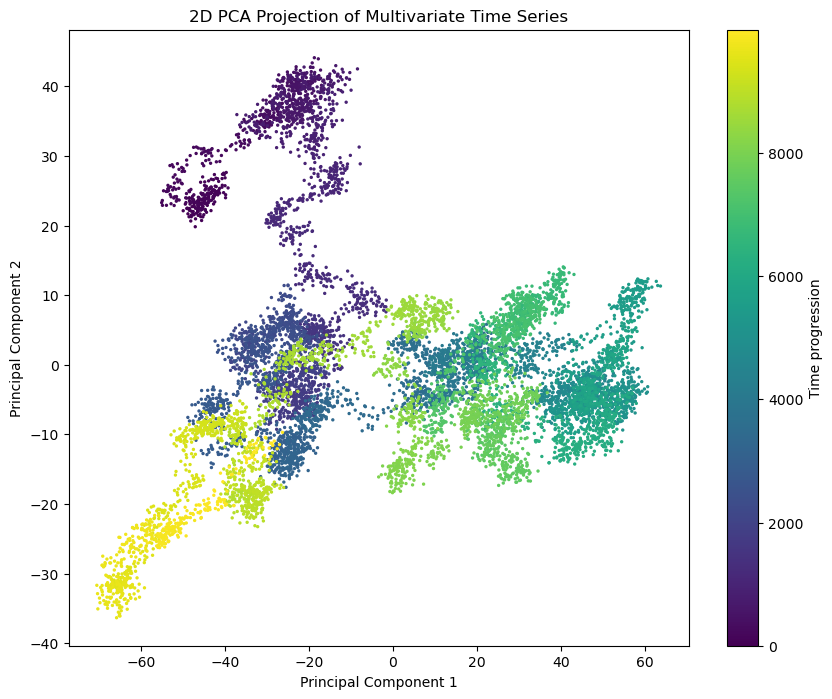

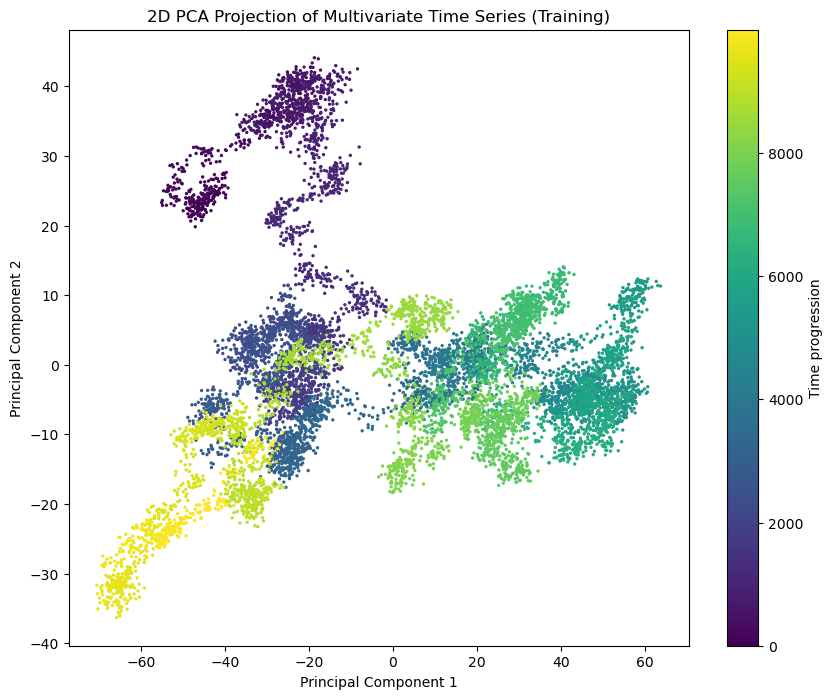

Testing Autoencoder-based Multivariate Tokenizer...
Training autoencoder + GQTokenizer on 10000 training samples...
Progress updates every 1000 steps:
Training step 500, autoencoder loss: 184.9209
Training step 1000, autoencoder loss: 81.6334
Training step 1500, autoencoder loss: 123.3997
Training step 2000, autoencoder loss: 21.2466
Training step 2500, autoencoder loss: 19.8309
Training step 3000, autoencoder loss: 18.6903
Training step 3500, autoencoder loss: 132.4418
Training step 4000, autoencoder loss: 4.6498
Training step 4500, autoencoder loss: 2.5891
Training step 5000, autoencoder loss: 5.6167
Training step 5500, autoencoder loss: 4.6648
Training step 6000, autoencoder loss: 20.5925
Training step 6500, autoencoder loss: 14.1915
Training step 7000, autoencoder loss: 2.1971
Training step 7500, autoencoder loss: 2.7097
Training step 8000, autoencoder loss: 4.4833
Training step 8500, autoencoder loss: 3.6311
Training step 9000, autoencoder loss: 71.0600
Training step 9500, autoenc

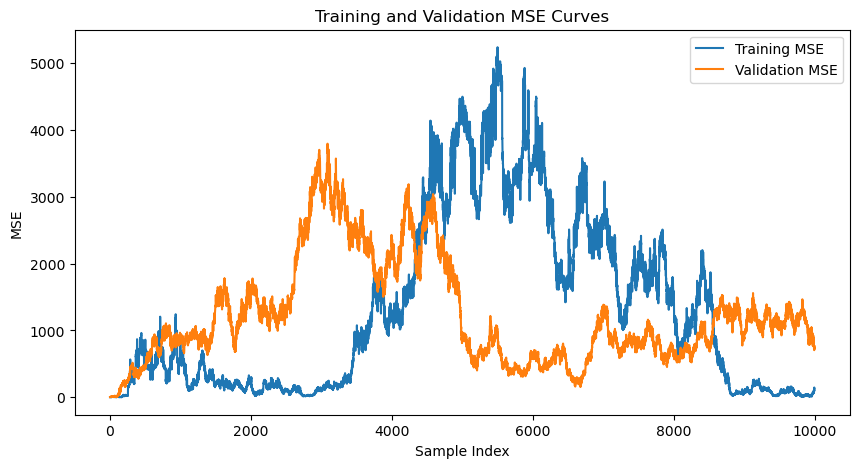

Vocabulary utilization on validation data: 14/16 tokens used

Per-dimension reconstruction quality on validation data:
Dim 0: correlation=-0.7014, MSE=3225.4904
Dim 1: correlation=0.7109, MSE=1112.9905
Dim 2: correlation=0.8128, MSE=123.7556
Dim 3: correlation=0.6511, MSE=487.4555

1D bottleneck signal statistics on validation data:
Bottleneck mean: 79.1747
Bottleneck std: 24.2844
Bottleneck range: [1.7615, 144.7243]


In [104]:
# Test parameters
D = 4
V = 16
T = 10_000

# Define a covariance matrix with positive covariances between different dimensions
cov_matrix = np.array([
    [1.0, 0.8, 0.5, 0.3],
    [0.8, 1.0, 0.4, 0.2],
    [0.5, 0.4, 1.0, 0.6],
    [0.3, 0.2, 0.6, 1.0]
])

# Perform Cholesky decomposition
L = np.linalg.cholesky(cov_matrix)

# Generate training autoregressive sequence with covariance
np.random.seed(42)  # For reproducibility
X_train = np.zeros((T, D))
for t in range(3, T):
    noise = np.random.randn(D)
    X_train[t] = (0.5 * X_train[t-1] + 0.3 * X_train[t-2] + 0.2 * X_train[t-3]) + np.dot(noise, L.T)

# Generate validation autoregressive sequence with covariance
np.random.seed(24)  # Different seed for validation
X_val = np.zeros((T, D))
for t in range(3, T):
    noise = np.random.randn(D)
    X_val[t] = (0.5 * X_val[t-1] + 0.3 * X_val[t-2] + 0.2 * X_val[t-3]) + np.dot(noise, L.T)

# Display a 2D PCA projection plot with a sequential color bar for training data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=np.arange(T), cmap='viridis', s=2)
plt.colorbar(label='Time progression')
plt.title('2D PCA Projection of Multivariate Time Series (Training)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# ================================

# Autoencoder-based Multivariate Demo
print("Testing Autoencoder-based Multivariate Tokenizer...")

print(f"Training autoencoder + GQTokenizer on {T} training samples...")
print("Progress updates every 1000 steps:")

# Initialize autoencoder tokenizer
ae_tok = AutoencoderTokenizer(D, V, hidden_dim=64)

# Train the autoencoder and GQTokenizer on training data
for t in range(T):
    ae_tok.update(X_train[t])

print(f"\nTraining completed! Total steps: {ae_tok.training_step}")

# Test encoding/decoding on validation data
print("\nTesting encoding/decoding on validation data...")
test_indices = [0, 2000, 4000, 6000, 8000]
for i in test_indices:
    original = X_val[i]
    token = ae_tok.encode(original)
    reconstructed = ae_tok.decode(token)
    mse = np.mean((original - reconstructed)**2)
    print(f"Sample {i}: token={token}, MSE={mse:.4f}")

# Encode all validation data and compute reconstruction quality
print(f"\nEncoding all {T} validation samples...")
all_tokens_val = np.array([ae_tok.encode(x) for x in X_val], dtype=int)
all_reconstructed_val = np.stack([ae_tok.decode(tok) for tok in all_tokens_val], axis=0)

# Compute overall reconstruction quality on validation data
overall_mse_val = np.mean((X_val - all_reconstructed_val)**2)
print(f"Overall MSE on validation data: {overall_mse_val:.4f}")

# Plot training and validation MSE curves
plt.figure(figsize=(10, 5))
plt.plot(np.arange(T), [np.mean((X_train[i] - ae_tok.decode(ae_tok.encode(X_train[i])))**2) for i in range(T)], label='Training MSE')
plt.plot(np.arange(T), [np.mean((X_val[i] - ae_tok.decode(ae_tok.encode(X_val[i])))**2) for i in range(T)], label='Validation MSE')
plt.xlabel('Sample Index')
plt.ylabel('MSE')
plt.title('Training and Validation MSE Curves')
plt.legend()
plt.show()

# Vocabulary utilization on validation data
unique_tokens_val = len(np.unique(all_tokens_val))
print(f"Vocabulary utilization on validation data: {unique_tokens_val}/{V} tokens used")

# Per-dimension correlation on validation data
print("\nPer-dimension reconstruction quality on validation data:")
for d in range(D):
    if np.std(all_reconstructed_val[:, d]) < 1e-8:
        print(f"Dim {d}: reconstructed variance ~0, correlation undefined")
        corr = np.nan
    else:
        corr = np.corrcoef(X_val[:, d], all_reconstructed_val[:, d])[0, 1]
    mse_d = np.mean((X_val[:, d] - all_reconstructed_val[:, d])**2)
    print(f"Dim {d}: correlation={corr:.4f}, MSE={mse_d:.4f}")

# Show the 1D bottleneck signal statistics on validation data
print(f"\n1D bottleneck signal statistics on validation data:")
bottleneck_signals_val = np.array([ae_tok.encode_continuous(x) for x in X_val])
print(f"Bottleneck mean: {np.mean(bottleneck_signals_val):.4f}")
print(f"Bottleneck std: {np.std(bottleneck_signals_val):.4f}")
print(f"Bottleneck range: [{np.min(bottleneck_signals_val):.4f}, {np.max(bottleneck_signals_val):.4f}]")
